# Speed comparison of CPU vs. GPU on pytorch with MNIST

## 0. imports

In [53]:
import time
from livelossplot import PlotLosses
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision

## 1. Data

In [59]:
# MNIST
trainset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=torchvision.transforms.ToTensor())
testset  = torchvision.datasets.MNIST(root=".", train=False, download=True, transform=torchvision.transforms.ToTensor())

## 3. Data preparation

In [58]:
# torch.tensor -> numpy.array
X_train = trainset.data.numpy()
y_train = trainset.targets.numpy()
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

# scaled from [0,255] to [0,1] for X
X_train = X_train / 255
X_test  = X_test / 255

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, train_size=50000, random_state=0
)

# Reshape 28 x 28 --> 784
X_train_flatten = X_train.reshape(50000, 28*28)
X_valid_flatten = X_valid.reshape(10000, 28*28)
X_test_flatten  = X_test.reshape(10000, 28*28)

# np.array --> torch.tensor
X_train_torch = torch.tensor(X_train_flatten, dtype=torch.float)
X_valid_torch = torch.tensor(X_valid_flatten, dtype=torch.float)
X_test_torch  = torch.tensor(X_test_flatten,  dtype=torch.float)

y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_valid_torch = torch.tensor(y_valid, dtype=torch.long)
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

# create dataset (keep X vs. Y rate)
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, y_valid_torch)
test_dataset  = torch.utils.data.TensorDataset(X_test_torch,  y_test_torch)

batch_size = 256

# Create dataloader (batch_size of X, Y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size)

## 4. Model train

### 4.1 define update model

In [54]:
def update_model(model, loss_fn, opt, train_loader):
    train_loss = 0
    train_correct = 0
    train_count = len(train_loader.dataset)

    for X, y in train_loader:
        y_pred = model(X) # Predict (before softmax)

        _, predicted = torch.max(y_pred.data, 1) # Get max class
        train_correct += (predicted == y).sum().item()

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()*len(y)

        # Update weight
        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss / train_count
    train_accuracy = train_correct / train_count

    return mean_train_loss, train_accuracy

### 4.2 define evaluate model

In [48]:
def evaluate_model(model, loss_fn, dataloader):
    model.eval() # be evalate mode

    valid_loss = 0
    valid_correct = 0
    valid_count = len(dataloader.dataset)

    for X, y in dataloader:
        y_pred = model(X)

        _, predicted = torch.max(y_pred.data, 1)
        valid_correct += (predicted == y).sum().item()

        loss = loss_fn(y_pred, y)
        valid_loss += loss.item()*len(y)

    mean_valid_loss = valid_loss / valid_count
    valid_accuracy = valid_correct / valid_count

    model.train() # Back to train mode
    return mean_valid_loss, valid_accuracy

### 4.3 define train 

In [49]:
def train(model, loss_fn, opt, train_loader, valid_loader, epoch=50):
    liveloss = PlotLosses() # Init plot
    for i in range(epoch):
        train_loss, train_accuracy = update_model(model, loss_fn, opt, train_loader)
        valid_loss, valid_accuracy = evaluate_model(model, loss_fn, valid_loader)

        # Visualize the loss and accuracy values.
        liveloss.update({
            'log loss': train_loss,
            'val_log loss': valid_loss,
            'accuracy': train_accuracy,
            'val_accuracy': valid_accuracy,
        })
        liveloss.draw()
        print('Train accuracy: {:.4f}'.format(train_accuracy))
        
    print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))
    return model

### 4.4 define model

In [50]:
torch.manual_seed(0)

slp = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10) # 28 x 28 --> 10 classes
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(slp.parameters(), lr=0.1)

### 4.5 training

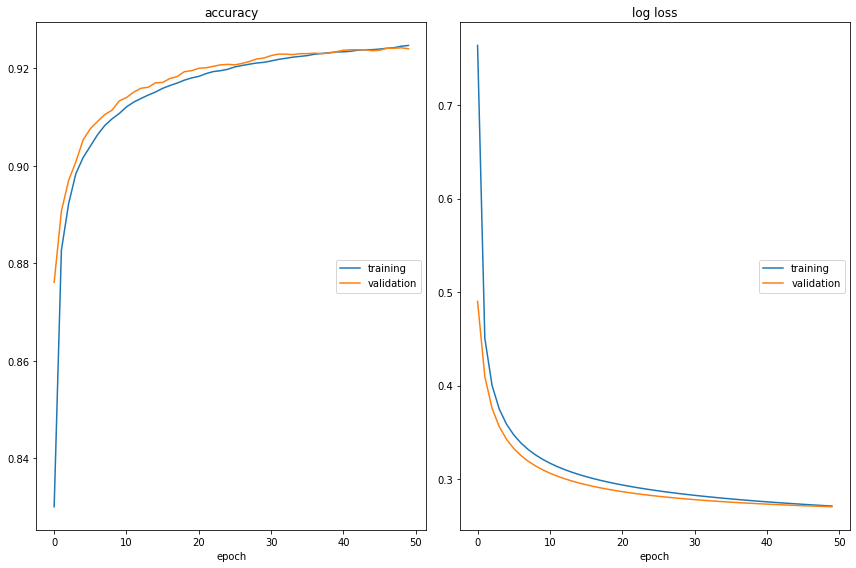

accuracy
	training         	 (min:    0.830, max:    0.925, cur:    0.925)
	validation       	 (min:    0.876, max:    0.924, cur:    0.924)
log loss
	training         	 (min:    0.271, max:    0.764, cur:    0.271)
	validation       	 (min:    0.270, max:    0.490, cur:    0.270)
Train accuracy: 0.9247
Accuracy: 0.9240 (valid), 0.9247 (train)
Execute time: 51 s


In [30]:
start_time = time.time()

trained_model = train(slp, loss_fn, optimizer, train_loader, valid_loader)

print('Executed time: %i s' % int(time.time() - start_time) )

## 5. Model train with Cuda

### 5.0 Check GPU

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


### 5.1 define update model cuda

In [52]:
def update_model_cuda(model, loss_fn, opt, train_loader):
    train_loss = 0
    train_correct = 0
    train_count = len(train_loader.dataset)

    for X, y in train_loader:
        X = X.cuda() # Transfer data to GPU
        y = y.cuda()
        y_pred = model(X)

        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()*len(y)

        # Uupdate weight
        opt.zero_grad()
        loss.backward()
        opt.step()

    mean_train_loss = train_loss / train_count
    train_accuracy = train_correct / train_count

    return mean_train_loss, train_accuracy

### 5.2 define evaluate model cuda

In [55]:
def evaluate_model_cuda(model, loss_fn, dataloader):
    model.eval()

    valid_loss = 0
    valid_correct = 0
    valid_count = len(dataloader.dataset)

    for X, y in dataloader:
        X = X.cuda()
        y = y.cuda()
        y_pred = model(X)

        _, predicted = torch.max(y_pred.data, 1)
        valid_correct += (predicted == y).sum().item()

        loss = loss_fn(y_pred, y)
        valid_loss += loss.item()*len(y)

    mean_valid_loss = valid_loss / valid_count
    valid_accuracy = valid_correct / valid_count

    model.train()
    return mean_valid_loss, valid_accuracy

### 5.3 define train cuda

In [57]:
def train_cuda(model, loss_fn, opt, train_loader, valid_loader, epoch=50):
    liveloss = PlotLosses()
    for i in range(epoch):
        train_loss, train_accuracy = update_model_cuda(model, loss_fn, opt, train_loader)
        valid_loss, valid_accuracy = evaluate_model_cuda(model, loss_fn, valid_loader)

        # Visualize the loss and accuracy values.
        liveloss.update({
            'log loss': train_loss,
            'val_log loss': valid_loss,
            'accuracy': train_accuracy,
            'val_accuracy': valid_accuracy,
        })
        liveloss.draw()
        print('Train accuracy: {:.4f}'.format(train_accuracy))
        
    print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))
    return model

### 5.4 define model cuda

In [56]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True # Fix calculate result on GPU

slp_cuda = torch.nn.Sequential(
    torch.nn.Linear(28*28, 10)
)
slp_cuda.cuda()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(slp.parameters(), lr=0.1)

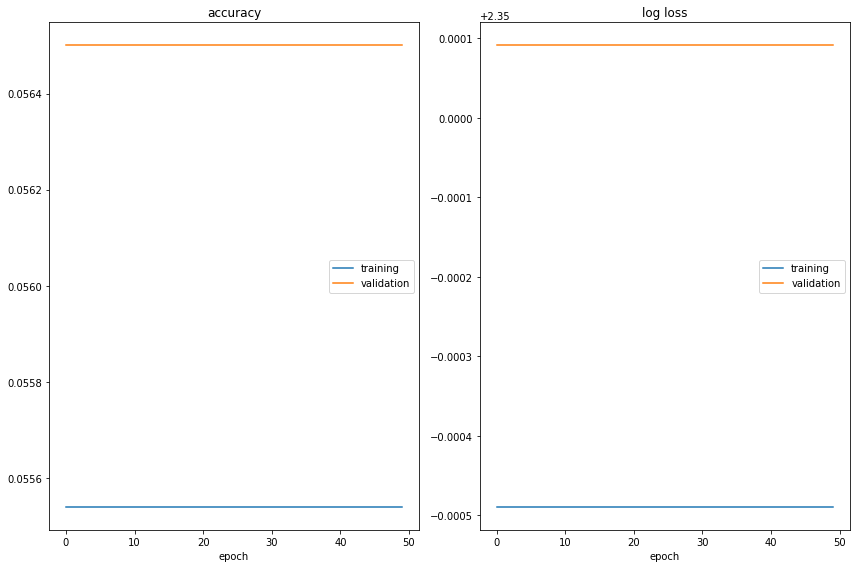

accuracy
	training         	 (min:    0.056, max:    0.056, cur:    0.056)
	validation       	 (min:    0.057, max:    0.057, cur:    0.057)
log loss
	training         	 (min:    2.350, max:    2.350, cur:    2.350)
	validation       	 (min:    2.350, max:    2.350, cur:    2.350)
Train accuracy: 0.0555
Accuracy: 0.0565 (valid), 0.0555 (train)
Execute time: 106 s


In [43]:
start_time = time.time()

trained_model_cuda = train_cuda(slp_cuda, loss_fn, optimizer, train_loader, valid_loader)

print('Execute time: %i s' % int(time.time() - start_time) )